In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numba

In [2]:
N = 96, 64
L = 15.0, 10.0
u = np.zeros(N)

In [3]:
# Arrays for setting the initial conditions
x = np.linspace(-0.5*L[0], 0.5*L[0], N[0])
y = np.linspace(-0.5*L[1], 0.5*L[1], N[1])
xv, yv = np.meshgrid(x, y, sparse=False, indexing='ij')

We'll define the type of boundary points as faces or edges using this labeling:
$$
\begin{pmatrix}
0 & 1 & 2 \\
3 &   & 4 \\
5 & 6 & 7 \\
\end{pmatrix}
$$
For example, a boundary point with type 7 is a lower right corner, 
with fluid flow on the bottom and left.

In [4]:
TOP, BOTTOM, LEFT, RIGHT = 1, 6, 3, 4
TOPL, TOPR, BOTL, BOTR = 0, 2, 5, 7

In [5]:
def calculate_boundary(mask):
    bpoints = []
    btype = []
    for i in range(1, mask.shape[0]-1):
        for j in range(mask.shape[1]-1):
            # Use bit operations to identify boundary points
            # Key value is 2**type
            key = mask[i+1, j-1]
            key <<= 1; key += mask[i, j-1]
            key <<= 1; key += mask[i-1, j-1]
            key <<= 1; key += mask[i+1, j]
            key <<= 1; key += mask[i-1, j]
            key <<= 1; key += mask[i+1, j+1] 
            key <<= 1; key += mask[i, j+1]
            key <<= 1; key += mask[i-1, j+1]
            if (key == 1 + 2 + 4):
                bpoints.append((i,j)); btype.append(TOP)
            elif (key == 1 + 8 + 32):
                bpoints.append((i,j)); btype.append(LEFT)
            elif (key == 4 + 16 + 128):
                bpoints.append((i,j)); btype.append(RIGHT)
            elif (key == 32 + 64 + 128):
                bpoints.append((i,j)); btype.append(BOTTOM)
            elif ((key & (255 - 4 - 32))  == 1 + 2 + 8):
                bpoints.append((i,j)); btype.append(TOPL)
            elif ((key & (255 - 1 - 128))  == 2 + 4 + 16):
                bpoints.append((i,j)); btype.append(TOPR)
            elif ((key & (255 - 1 - 128))  == 8 + 32 + 64):
                bpoints.append((i,j)); btype.append(BOTR)
            elif ((key & (255 - 4 - 32))  == 16 + 64 + 128):
                bpoints.append((i,j)); btype.append(BOTR)
    return np.array(bpoints), np.array(btype)

In [6]:
# Make shape for boundary: a trapazoid
mask = np.ones(N, dtype=np.uint8)
mask[35:64,32:34] = 0
mask[37:58,34] = 0
mask[40:54,35] = 0
mask[42:50,36] = 0

bpoints, btype = calculate_boundary(mask)

In [7]:
@numba.jit(nopython=True)
def smooth(u, mask):
    for i in range(1, N[0]-1):
        for j in range(1 + i % 2, N[1]-1, 2):
            u[i,j] = mask[i,j] * 0.25 * (u[i+1,j] + u[i,j+1] + u[i-1,j] + u[i,j-1]) \
                   + (1-mask[i,j]) * u[i,j]
    for i in range(1, N[0]-1):
        for j in range(2 - i % 2, N[1]-1, 2):
            u[i,j] = mask[i,j] * 0.25 * (u[i+1,j] + u[i,j+1] + u[i-1,j] + u[i,j-1]) \
                               + (1-mask[i,j]) * u[i,j]

In [8]:
@numba.jit(nopython=True)
def apply_bc(u):
    for icell in range(len(btype)):
        i, j = bpoints[icell]
        itype = btype[icell]
        if (itype == TOP):
            u[i,j] = u[i,j+2]
        elif (itype == BOTTOM):
            u[i,j] = u[i,j-2]
        elif (itype == LEFT):
            u[i,j] = u[i-2,j]
        elif (itype == RIGHT):
            u[i,j] = u[i+2,j]
        elif (itype == TOPL):
            u[i,j] = 0.5 * (u[i,j+2] + u[i-2,j])
        elif (itype == TOPR):
            u[i,j] = 0.5 * (u[i,j+2] + u[i+2,j])
        elif (itype == BOTL):
            u[i,j] = 0.5 * (u[i,j-2] + u[i-2,j])
        elif (itype == BOTR):
            u[i,j] = 0.5 * (u[i,j-2] + u[i+2,j])        

In [9]:
@numba.jit(nopython=True)
def force():
    fx, fy = np.zeros(N), np.zeros(N)
    for icell in range(len(btype)):
        i, j = bpoints[icell]
        itype = btype[icell]
        if (itype == TOP):
            fy[i,j] += v[i,j+1]**2
        elif (itype == BOTTOM):
            fy[i,j] -= v[i,j-1]**2
        elif (itype == LEFT):
            fx[i,j] -= v[i-1,j]**2
        elif (itype == RIGHT):
            fx[i,j] += v[i+1,j]**2
        elif (itype == TOPL):
            fx[i,j] -= v[i-1,j]**2
            fy[i,j] += v[i,j+1]**2
        elif (itype == TOPR):
            fx[i,j] += v[i+1,j]**2
            fy[i,j] += v[i,j+1]**2
        elif (itype == BOTL):
            fx[i,j] -= v[i-1,j]**2
            fy[i,j] -= v[i,j-1]**2
        elif (itype == BOTR):
            fx[i,j] += v[i+1,j]**2
            fy[i,j] -= v[i,j-1]**2
    return fx, fy

In [10]:
# Initial conditions (uniform flow to the right)
u[:,:] = -xv

In [11]:
apply_bc(u)
for i in range(1000):
    smooth(u, mask)
    apply_bc(u)

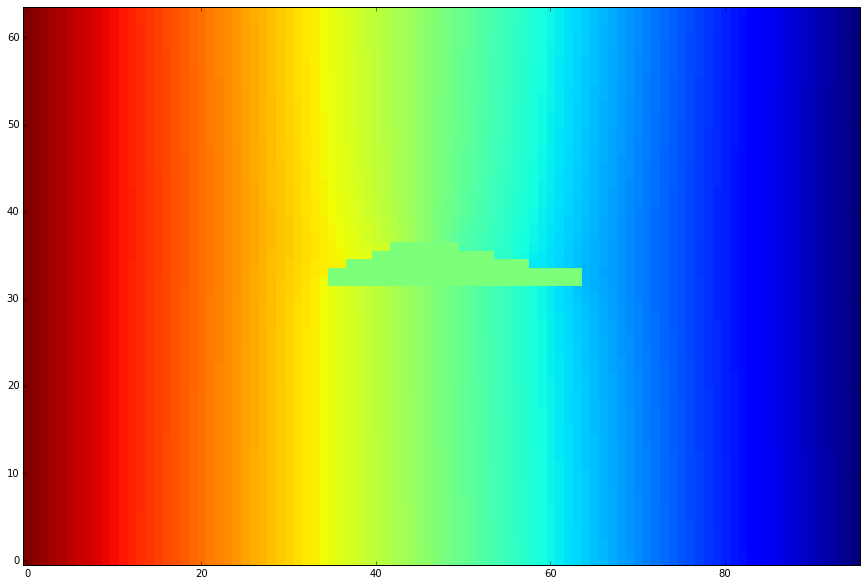

In [12]:
plt.imshow((mask*u).transpose(), origin="lower", interpolation='nearest'); plt.gcf().set_size_inches(15,10)

In [13]:
dx, dy = np.gradient(u)
dx[mask==0] = 0
dy[mask==0] = 0
v = np.sqrt(dx**2 + dy**2)

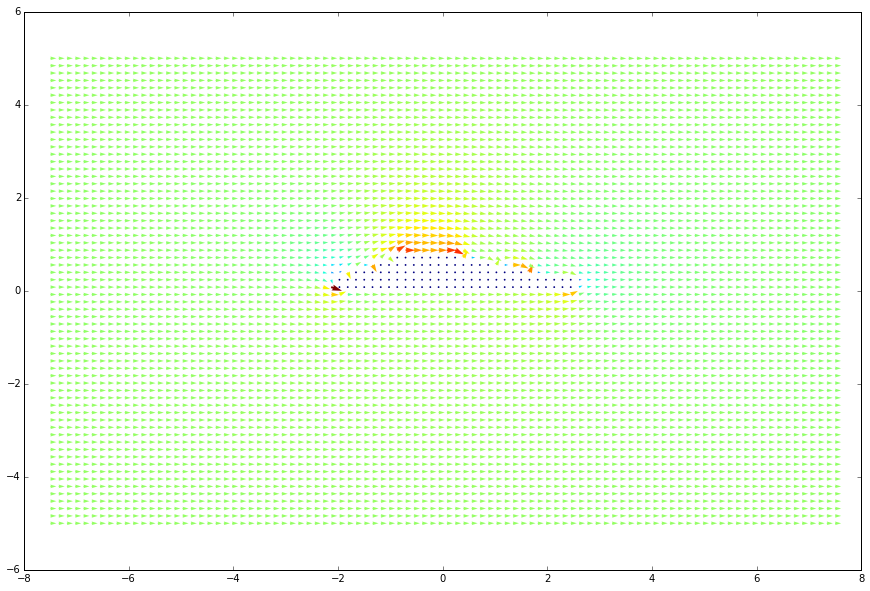

In [14]:
plt.quiver(xv, yv, -dx, -dy, v); plt.gcf().set_size_inches(15,10)

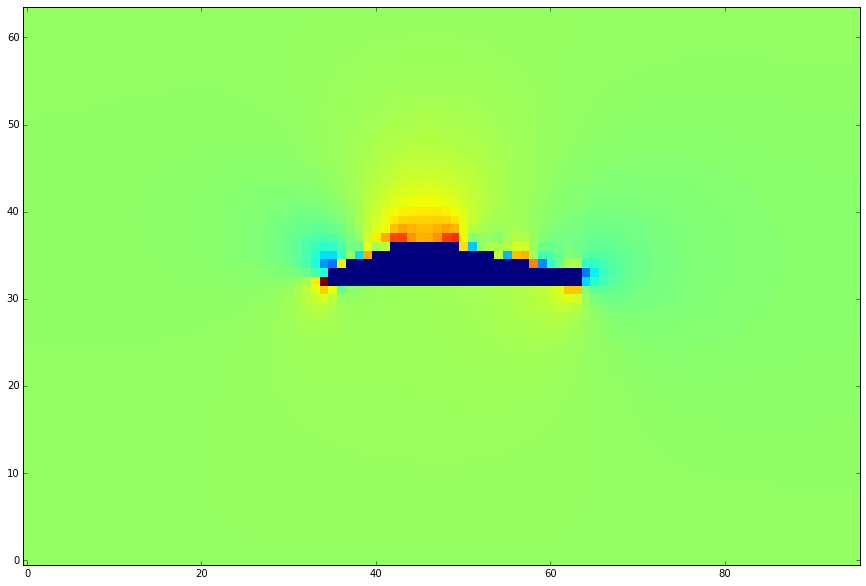

In [15]:
plt.imshow(v.transpose(), origin="lower", interpolation='nearest'); plt.gcf().set_size_inches(15,10)

In [16]:
fx, fy = force()

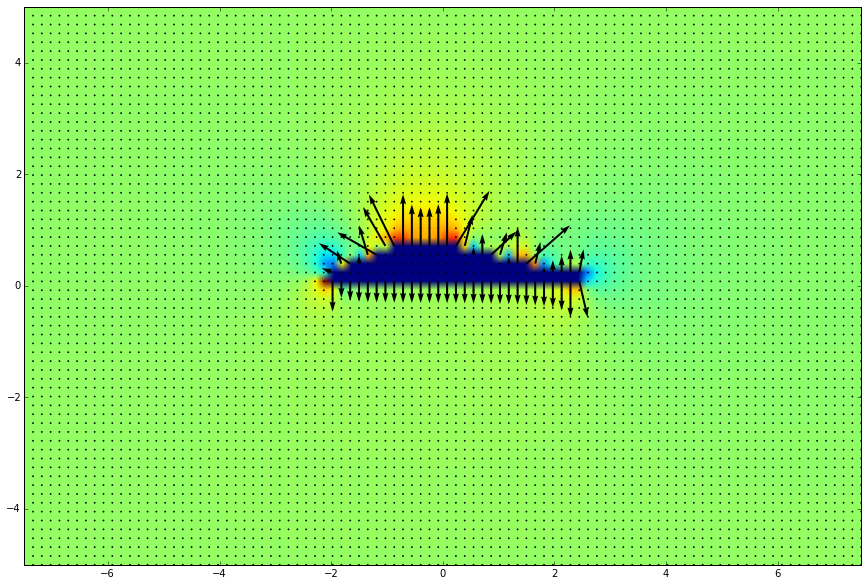

In [21]:
plt.quiver(xv, yv, fx, fy, scale=1.);
plt.imshow(v.transpose(), origin="lower", extent=(-7.5,7.5,-5,5));
plt.gcf().set_size_inches(15,10)

In [18]:
fx.sum(), fy.sum()

(-0.0086675280635148677, 0.13833851752620863)